In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import  butter, filtfilt,sosfiltfilt
from scipy.signal import find_peaks, peak_prominences, peak_widths

import time
from scipy.optimize import curve_fit
import scipy.special as special
from pathlib import Path
from scipy.signal import find_peaks
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
from scipy import fftpack 
from scipy import signal 
from matplotlib import cm
%matplotlib widget

In [2]:
# Bandpass filter

def translation(order, Wn, btype, fs, x):
    a,b = butter(order, Wn, btype, fs = fs)
    x_f= filtfilt(a,b, x)
    return x_f

In [3]:
# find the nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [4]:
#convert from timestamp to seconds
def timestamps_to_seconds(timestamps, starttime):
    """
    Convert a list of timestamps in "hh:mm" format into seconds.

    Parameters:
    timestamps (list): The list of timestamps to convert.

    Returns:
    list: A list of times converted into seconds.
    """
    seconds = []
    # convert the first timestamp into seconds and use it as start_time
    start_min, start_sec = map(int, starttime.split(':'))
    start_time = start_min * 60 + start_sec 
    
    for timestamp in timestamps:
        # split the timestamp into hours and minutes
        minu, sec = map(int, timestamp.split(':'))
        # convert to seconds and subtract start_time
        seconds.append(minu * 60 + sec  - start_time)
        
    return seconds


In [5]:
# folder path
dir_path = os.getcwd()
# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        if path.endswith('.txt'):
            res.append(path)
print(res)
files=res


['ch7.m1.txt', 'ch7.m10.txt', 'ch7.m11.txt', 'ch7.m12.txt', 'ch7.m13.txt', 'ch7.m2.txt', 'ch7.m3.txt', 'ch7.m4.txt', 'ch7.m5.txt', 'ch7.m6.txt', 'ch7.m7.txt', 'ch7.m8.txt', 'ch7.m9.txt', 'ch8.m1.txt', 'ch8.m2.txt']


In [6]:
#sort filenames
from tkinter import Tcl
files=Tcl().call('lsort', '-dict', res)

In [7]:
#start time of measuremnt set

start_time="0:00"
timestamps=['1:50','3:50','6:30','8:30','10:50','12:50','15:20','17:20','19:50','21:50','24:20','26:20','28:40','35:00','37:00']
time_stemps= timestamps_to_seconds(timestamps,start_time)

In [8]:
#load data and combine to one dataframe


x=[]
t=[]
i=0
for name in files:
    df = pd.read_csv(name, skiprows=1, sep='\t' ,names=["time","value"])
    t_new=df['time'].to_numpy()
    x_new=df['value'].to_numpy()
    t=np.append(t,time_stemps[i]*1e4+t_new)
    x=np.append(x,x_new)
    i+=1

In [9]:
 #only used if no time time_stemps availibe
x=[]
t=[]
border=np.zeros(len(files))
i=0
for name in files:
    df = pd.read_csv(name, skiprows=1, sep='\t' ,names=["time","value"])
    t_new=df['time'].to_numpy()
    x_new=df['value'].to_numpy()
    if name == files[0]:
        t=t_new
        x=x_new
        border[i]=t_new[-1]
        i+=1
    else:
        t=np.append(t,max(t)+t_new)
        x=np.append(x,x_new)
        border[i]=t[-1]
        i+=1
        
        
        

In [9]:
#time to secounds
t=t*1e-4

In [10]:
rate=1e-4

First important parameter Wn describes the amount of smoothening. That parameter needs to be adjusted by comparing peaks between smoothed data and raw data

In [11]:
#apply lowpass filterfilter for smoothening (otional)
order = 2
Wn = 1200  #in Hz _________________________________________<---------------- ADJUST---------------->
btype = 'lowpass'
fs = 1/rate  # in Hz
x_filter=translation(order, Wn, btype, fs,x)


#apply high filter for offset correction (otional)
#order = 2
#Wn = 0.1  #in Hz
#btype = 'highpass'
#fs = 1/rate  # in Hz
#x_filter=translation(order, Wn, btype, fs,x_filter)


In [12]:
#Function that finds peaks with the find_peak function. Afterwards filters out all peaks that are to close to start and end of the data. 

def find_peaks_with_window(data, window, **kwargs):
    peaks, properties = find_peaks(data, **kwargs)
    
    # filter out peaks near the start and end of the data
    valid_indices = (peaks >= 5*window) & (peaks <= len(data) - 5*window)
    peaks = peaks[valid_indices]
    
    # filter properties with valid_indices
    for key in properties:
        properties[key] = properties[key][valid_indices]
    
    return peaks, properties



Important parameter **height_lim** definds the treshold for the minimal height of detected peaks 

In [13]:
height_lim=17 # <---------------- ADJUST----------------->

Important parameter **window** definds several things: 
   1. used as the **distance_threshold** parameter which defindes what is the maximal distance that two peaks are seperrated
   2. defindes the window in the **find_peaks_with_window** function
   3. defindes the width of a peak during inspection of a peak 

In [14]:
window = 400# <---------------- ADJUST----------------->

The next part detects peaks at 35% height (*bottom*) and at 70% height. I used to compare these two values, but in this skript only the bottom value is used. Later all peaks are selected that have a secound peak within the distance **distance_threshold**. This way only double peaks are selected  

In [15]:


# Detect peaks
peaks_x_filter, amp_x_filter = find_peaks_with_window(x_filter, window, width=[1,2000], prominence=height_lim, distance=5,rel_height=0.30)

# Set the distance threshold
distance_threshold = window  # substitute x with the actual value





# Create new lists to store the filtered peaks and corresponding amplitudes
filtered_peaks_x = [peaks_x_filter[0]]  # Start with the first peak

# Initialize filtered_amp_x as an empty dictionary with similar keys as amp_x_filter but with empty lists as values
filtered_amp_x = {key: [] for key in amp_x_filter.keys()}

# Start with the first peak properties
for key in filtered_amp_x.keys():
    filtered_amp_x[key].append(amp_x_filter[key][0])

for i in range(1, len(peaks_x_filter)):
    # If the current peak is farther than the threshold distance from the last filtered peak, add it to the filtered list
    if peaks_x_filter[i] - filtered_peaks_x[-1] > distance_threshold:
        filtered_peaks_x.append(peaks_x_filter[i])
        
        # Also append the corresponding amplitude (and other properties) for each key in amp_x_filter
        for key in filtered_amp_x.keys():
            filtered_amp_x[key].append(amp_x_filter[key][i])

# Now filtered_peaks_x contains only the first peaks that are 'x' distance apart
# And filtered_amp_x contains the corresponding peak properties

# Repeat for the peaks and amplitudes with rel_height=0.65
peaks_x_filter_bottom, amp_x_filter_bottom = find_peaks_with_window(x_filter, window, width=[1,2000], prominence=height_lim, distance=5,rel_height=0.65)

# Create new lists to store the filtered peaks and corresponding amplitudes
filtered_peaks_x_bottom = [peaks_x_filter_bottom[0]]  # Start with the first peak

# Initialize filtered_amp_x_bottom as an empty dictionary with similar keys as amp_x_filter_bottom but with empty lists as values
filtered_amp_x_bottom = {key: [] for key in amp_x_filter_bottom.keys()}

# Start with the first peak properties
for key in filtered_amp_x_bottom.keys():
    filtered_amp_x_bottom[key].append(amp_x_filter_bottom[key][0])

for i in range(1, len(peaks_x_filter_bottom)):
    # If the current peak is farther than the threshold distance from the last filtered peak, add it to the filtered list
    if peaks_x_filter_bottom[i] - filtered_peaks_x_bottom[-1] > distance_threshold:
        filtered_peaks_x_bottom.append(peaks_x_filter_bottom[i])
        
        # Also append the corresponding amplitude (and other properties) for each key in amp_x_filter_bottom
        for key in filtered_amp_x_bottom.keys():
            filtered_amp_x_bottom[key].append(amp_x_filter_bottom[key][i])

# Now filtered_peaks_x_bottom contains only the first peaks that are 'x' distance apart
# And filtered_amp_x_bottom contains the corresponding peak properties


In [16]:
# set the filtered peaks as the peaks
peaks_x_filter=filtered_peaks_x
amp_x_filter = filtered_amp_x
peaks_x_filter_bottom=filtered_peaks_x_bottom
amp_x_filter_bottom=filtered_amp_x_bottom

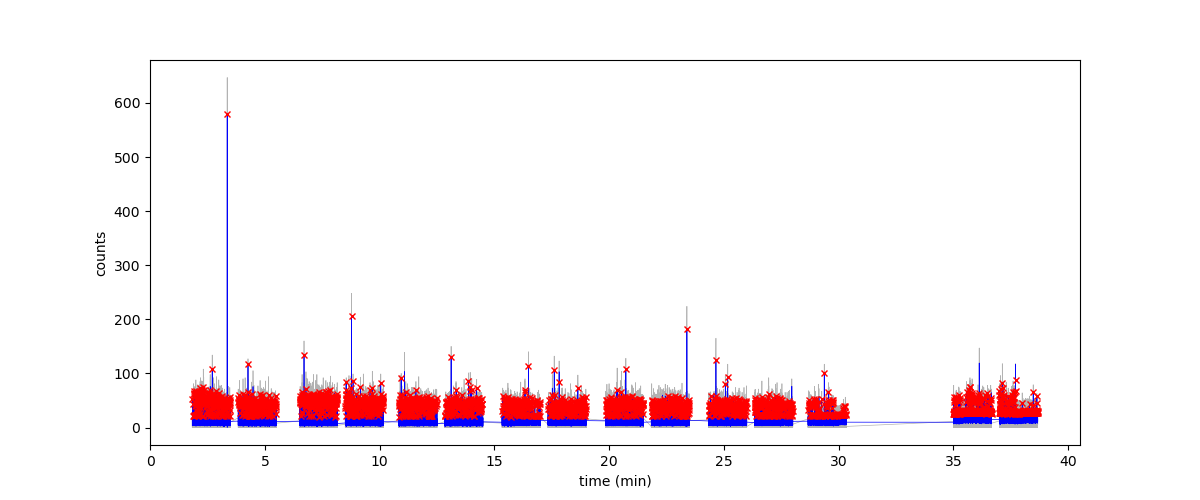

In [17]:
#inspect raw data and smoothed data
fig, ax = plt.subplots(figsize=(12, 5))

line,=ax.plot(t/60, x,color='black',linewidth=0.5,alpha=.3)
line,=ax.plot(t/60, x_filter,color='blue',linewidth=0.5)
ax.plot(t[filtered_peaks_x]/60, x_filter[filtered_peaks_x], "x",color='red',ms=5 )
# start of each measurement
#for xc in time_stemps:
#        plt.axvline(x = xc/60, color = 'black', linewidth=0.5, linestyle='--')

ax.set_xlabel('time (min)')
ax.set_ylabel('counts')
plt.show()

In [18]:
fig.savefig('timetrace.svg', format="svg", bbox_inches='tight')

The next cell inspects the individual detected peaks. 
1. Check if double peaks are present 
2. Check if smoothing is not to much and the peak width is bekomming wider then the raw data peak

adjust smoothing detected peak height and window size until individual peaks are fine

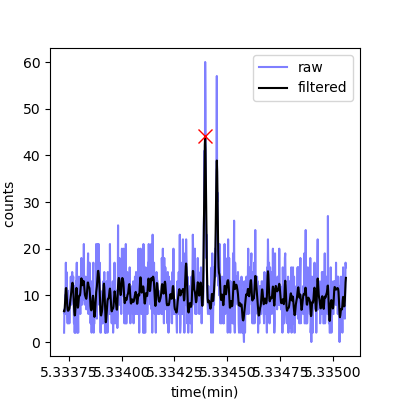

In [19]:
# inspect individual peaks 

#windowsize left and  right of a peak 
#random peak index i is manually adjusted to inspect different peaks
i=500 #<------ADJUST------>


# RAW data
Datay=x
Datax=t
xData=Datax[peaks_x_filter[i]-window:peaks_x_filter[i]+window]
yData=Datay[peaks_x_filter[i]-window:peaks_x_filter[i]+window]

#Plot peak
fig,ax = plt.subplots(figsize=(4, 4))
ax.plot(xData/60, yData,color='blue', label='raw', alpha=0.5)



# Smoothed DATA

Datay=x_filter
yData=Datay[peaks_x_filter[i]-window:peaks_x_filter[i]+window]
# start values

ax.plot(xData/60, yData,color='black', label='filtered', alpha=1)

ax.hlines(y=amp_x_filter["width_heights"][i], xmin=t[int(amp_x_filter["left_ips"][i])]/60,xmax=t[int(amp_x_filter["right_ips"][i])]/60, color = "red")

ax.plot(t[peaks_x_filter[i]]/60, x_filter[peaks_x_filter[i]], "x",color='red',ms=10 )
ax.set_xlabel('time(min)')
ax.set_ylabel('counts ')
ax.legend()
plt.show()

In [20]:
#Save example peak
fig.savefig('peaks_eaxample1.svg', format="svg", bbox_inches='tight')

# Find mean peak values

The next sections of the skript try to caculate a mean peak value. That is done to increase the S/N ratio. 
The parameter **intervall** needs to be adjusted. It intervall in seconds in which all peaks are averaged

In [21]:
# time intervallin seconds in which all peaks are averaged 
intervall=10

#select all peaks in that time intervall
peaks_intervall={}
index=0
position=np.arange(0,max(t[peaks_x_filter]),intervall)
peaks=np.zeros(len(position))
peaks[index]=find_nearest(t[peaks_x_filter], position[1])
peaks_intervall[index]=np.arange(peaks[index])
index+=1
for i in np.arange(1,len(position)-1):
    peaks[i]=find_nearest(t[peaks_x_filter], position[i])
    peaks[i+1]=find_nearest(t[peaks_x_filter], position[i+1])
    peaks_intervall[index]=np.arange(peaks[index],peaks[index+1])
    index+=1  

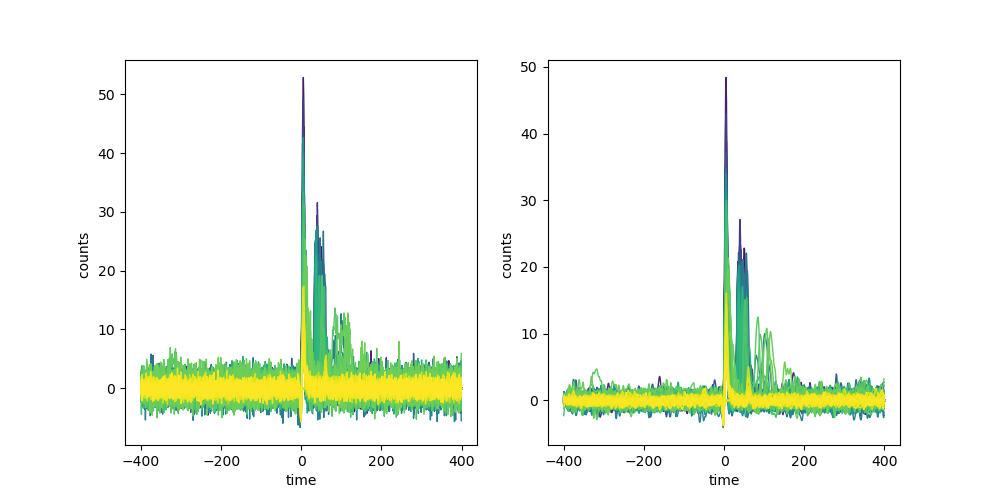

In [22]:


# calculate the mean peaks in each interval 


#windowsize left and  twice on the right of a peak 

colormap=cm.get_cmap('viridis', int(len(peaks_intervall)))

fig,ax = plt.subplots(1,2,figsize=(10, 5))

Datax=t

#Peak time array
time=np.arange(-window,window)

#Select RAW data     
    
Datay=x

# define parameter
mean_peak={}


#Caculate mean peak value

index_run=0
for k in peaks_intervall:
    sum_yData=np.zeros(2*window) #define array over which all peaks are summed
    if len(peaks_intervall[k])>2:# the minimmial number of peaks for each intervall <-----ADJUST------> That parameter depends on the qulity of the data.  If you have a lot of peaks but bad S/N parameter the parameter is high (for example 5). If you have high quality but little data parameter small (for example 2) 
        for i in peaks_intervall[k]: 
            xData=Datax[int(amp_x_filter_bottom["left_ips"][int(i)])-window:int(amp_x_filter_bottom["left_ips"][int(i)])+window] 
            yData=Datay[int(amp_x_filter_bottom["left_ips"][int(i)])-window:int(amp_x_filter_bottom["left_ips"][int(i)])+window]
            sum_yData += yData # sum peaks
        mean_peak[k]=(sum_yData-np.mean(sum_yData[0:10]))/len(peaks_intervall[k]) # normalize by number of detected peaks / remove offset
    else: 
         mean_peak[k]=sum_yData=np.zeros(2*window)
    ax[0].plot(time, mean_peak[k],color=colormap(int(k)), label='raw',alpha=1, linewidth=1) # plot 
    

ax[0].set_xlabel('time')
ax[0].set_ylabel('counts ')



#Select smoothed data 

Datay=x_filter




# define parameter
mean_peak_filter={}


#Caculate mean peak value
index_run=0
for k in peaks_intervall:
    #define array over which all peaks are summed
    sum_yData=np.zeros(2*window)
    if len(peaks_intervall[k])>2:# the minimmial number of peaks for each intervall <-----ADJUST------> That parameter depends on the qulity of the data.  If you have a lot of peaks but bad S/N parameter the parameter is high (for example 5). If you have high quality but little data parameter small (for example 2) 
        for i in peaks_intervall[k]: 
            xData=Datax[int(amp_x_filter_bottom["left_ips"][int(i)])-window:int(amp_x_filter_bottom["left_ips"][int(i)])+window] 
            yData=Datay[int(amp_x_filter_bottom["left_ips"][int(i)])-window:int(amp_x_filter_bottom["left_ips"][int(i)])+window]
            sum_yData += yData # sum peaks
        mean_peak_filter[k]=(sum_yData-np.mean(sum_yData[0:10]))/len(peaks_intervall[k]) # normalize by number of detected peaks / remove offset
    else: 
         mean_peak_filter[k]=sum_yData=np.zeros(2*window)
        
    ax[1].plot(time, mean_peak_filter[k],color=colormap(int(k)), label='filter',alpha=1, linewidth=1) # plot 

ax[1].set_xlabel('time')
ax[1].set_ylabel('counts ')






plt.show()

A negative dip before the first peak indicates that the **height_lim** parameter is too low and you also detect noise 

In [23]:
fig.savefig('averaged peaks.svg', format="svg", bbox_inches='tight') # save figure

## Option 1: Smooth RAW data

ether execute Optin 1 or Option 2, because the parameter are overwritten 

In [24]:
#Parameter for smoothing

order = 2
Wn = 1200  #in Hz <-----------Adjust----------->
btype = 'lowpass'
fs = 1/rate  # in Hz

Adjust the **height_lim_av** parameter so that the two peaks are detected. Thiis critical otherwise the distance is not calculated 

In [25]:
#parameter for peak detection
height_lim_av=6.5 # <-----------------Adjust------------------>

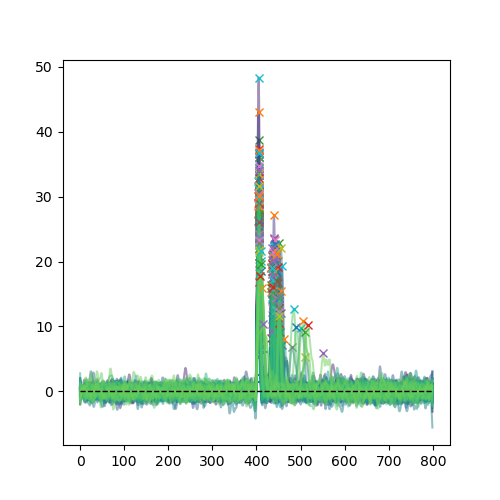

In [26]:
#Display the detected peaks adjust 
fig, ax = plt.subplots(figsize=(5, 5))
peaks_width_new=np.zeros(len(mean_peak)) # new parameter for saving the peak width
distance=np.zeros(len(mean_peak)) # new parameter for saving the distance
for k in mean_peak:
    mean_peak_smooth=translation(order, Wn, btype, fs,mean_peak[k]) # smooth data
    peaks, peaks_para = find_peaks(mean_peak_smooth[int(window):],width=[1,10000], prominence=height_lim_av,rel_height=0.75) # find peaks
    if len(peaks) > 1: # only display if more than two peaks are found
        ax.hlines(y=peaks_para["width_heights"][0], xmin=int(window)+peaks_para["left_ips"][0],xmax=peaks_para["right_ips"][0]+int(window), ) # plot width
        peaks_width_new[k]=peaks_para['widths'][0] # save width
        distance[k]=peaks[1]-peaks[0] # save distance
        ax.plot(mean_peak_smooth,color = colormap(k),alpha=0.5) #plot peaks
        ax.plot(peaks+int(window), mean_peak_smooth[int(window)+peaks], "x") # plot peak
ax.plot(np.zeros_like(mean_peak_smooth), "--", color="black", linewidth=1)# zero line
plt.show()

## Option 2: ananlyze smoothed data 

In [27]:
#parameter for peak detection
height_lim_av_s=7# <-----------------Adjust------------------>

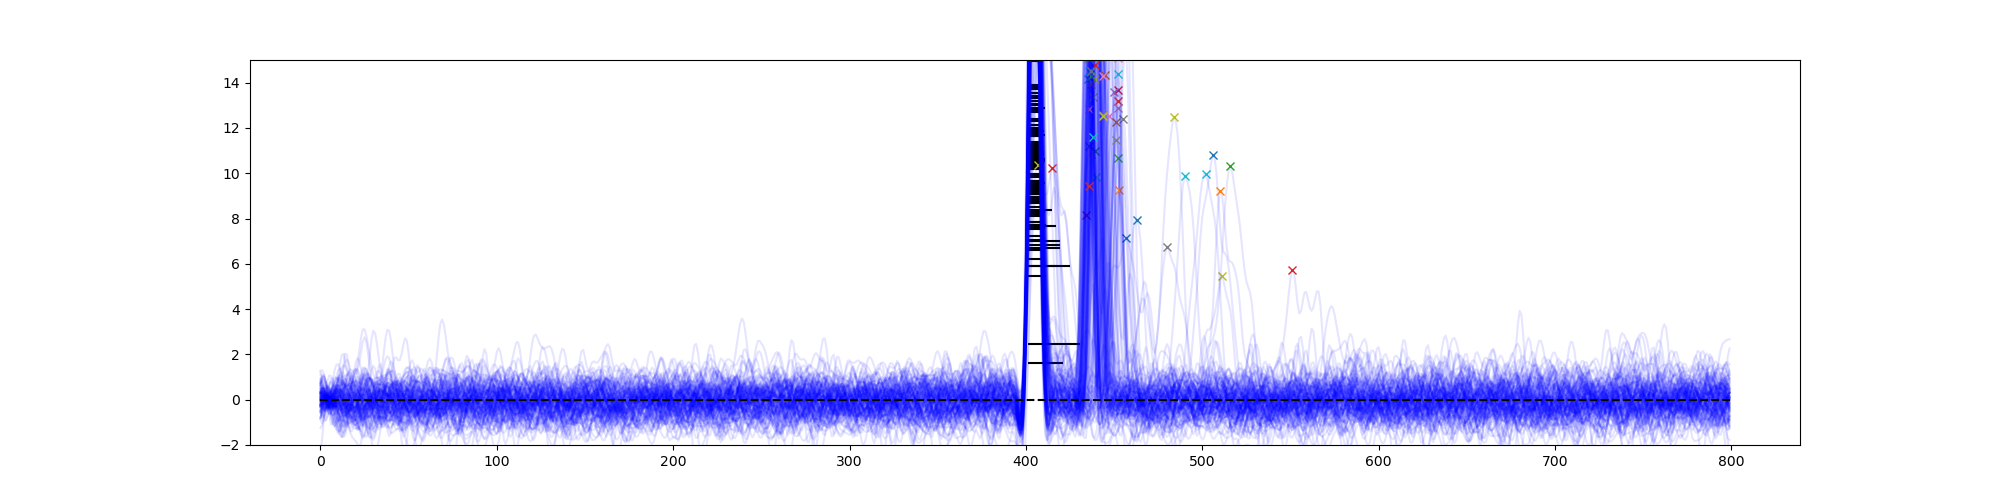

In [28]:
fig, ax = plt.subplots(figsize=(20, 5))
peaks_width_new=np.zeros(len(mean_peak_filter))
distance=np.zeros(len(mean_peak_filter))
amplitude=np.zeros(len(mean_peak_filter))
for k in mean_peak:
    peaks, peaks_para = find_peaks(mean_peak_filter[k][int(window):],width=[1,10000], prominence=height_lim_av_s,rel_height=0.75)
    if len(peaks) > 1:
        ax.hlines(y=peaks_para["width_heights"][0], xmin=int(window)+peaks_para["left_ips"][0],xmax=int(window)+peaks_para["right_ips"][0], color = "black")
        peaks_width_new[k]=peaks_para['widths'][0]
        distance[k]=peaks[1]-peaks[0]
        amplitude[k]=peaks_para['prominences'][0]
        ax.plot(mean_peak_filter[k],color='blue',alpha=0.1)
        ax.plot(int(window)+peaks, mean_peak_filter[k][int(window)+peaks], "x")
ax.plot(np.zeros_like(mean_peak_filter[0]), "--", color="black")
ax.set_ylim(-2,15)
plt.show()

In [29]:
peaks_width=peaks_width_new[peaks_width_new!= 0] #remove zero
distance_n=distance[distance!= 0]#remove zero
Laser_seperation=6000e-9 # laser spot seperation in m

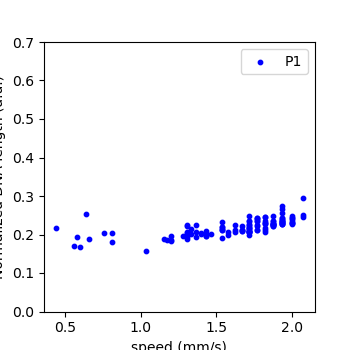

In [30]:
# Plot Normalized DNA length
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.scatter((Laser_seperation)/(distance_n*1e-4)*1e3,peaks_width/distance_n, s=10, color='blue', label="P1")
ax.set_ylim(0, 0.7)
ax.set_ylabel('Normalized DNA length (a.u.)')
ax.set_xlabel('speed (mm/s)')
plt.legend()


In [31]:
fig.savefig('dna length.svg', format="svg", bbox_inches='tight')

In [32]:
# time trace
time_position=np.arange(0,max(t[peaks_x_filter]),intervall)

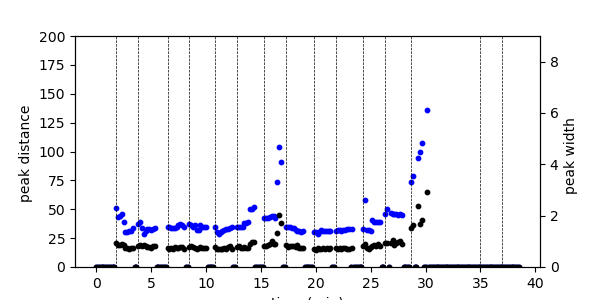

In [33]:
# plot the width and distance over time 

fig, ax = plt.subplots(figsize=(6, 3))
ax2 = ax.twinx()

ax.scatter(time_position[:-1]/60,distance, s=10, alpha=1, color='blue',label="distance")
ax2.scatter(time_position[:-1]/60,peaks_width_new*1e-1, s=10, alpha=1, color='black', label="width")
for xc in time_stemps:
    plt.axvline(x = xc/60, color = 'black', linewidth=0.5, linestyle='--')


ax.set_xlabel('time (min)')
ax.set_ylabel('peak distance ')
ax2.set_ylabel('peak width  ')
ax.set_ylim(0,200)
ax2.set_ylim(0,9)
plt.show()

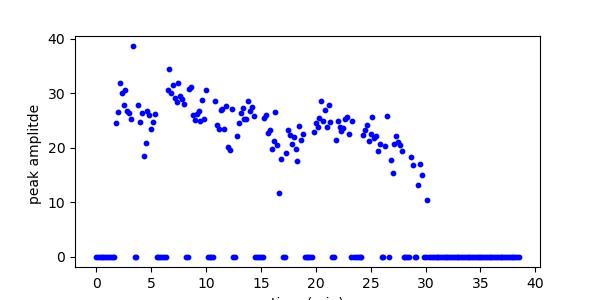

In [34]:
#plot the amplitude of the first peak 
fig, ax = plt.subplots(figsize=(6, 3))

ax.scatter(time_position[:-1]/60,amplitude, s=10, alpha=1, color='blue',label="distance")
ax.set_xlabel('time (min)')
ax.set_ylabel('peak amplitde ')
plt.show()

In [35]:
fig.savefig("speeds DNA.svg",bbox_inches='tight')

Create a grid for color coded plotting

In [36]:
# RAW data
grid = []
for i in peaks_intervall:
    grid.append(mean_peak[i])

In [37]:
# smoothed data 
grid_filter = []
for i in peaks_intervall:
    grid_filter.append(mean_peak_filter[i])

In [38]:
time_position=np.arange(0,int(max(t)),intervall) # y-axsis 
peak_time=np.arange(-window,window)*1e-1 # x- axsis

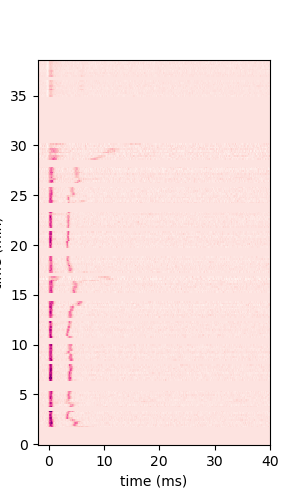

In [39]:
# plot the Raw DATA  
fig, ax = plt.subplots(figsize=(3, 5))

ax.pcolor(peak_time,time_position/60,grid,cmap='RdPu',shading='auto')
ax.set_xlabel('time (ms)')
ax.set_ylabel('time (min)')
ax.set_xlim(-2,40)

plt.show()

In [40]:
fig.savefig('average_peak_over_time.svg', format="svg", bbox_inches='tight') # save figure

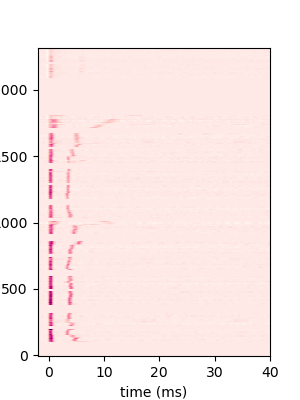

In [41]:
# plot the smothed DATA  
fig, ax = plt.subplots(figsize=(3, 4))

ax.pcolor(peak_time,time_position,grid_filter,cmap='RdPu',shading='auto')

ax.set_xlabel('time (ms)')
ax.set_ylabel('time (s)')
lim = ax.get_ylim()
ax.set_xlim(-2,40)
plt.show()

In [44]:
df_average = pd.DataFrame({"distance": distance,"time": time_position[:-1], "width":peaks_width_new, "amplitude": amplitude, 'serie':'A', 'Date':'5.07.23'} ) # save data to a Datafrane
df_average.to_csv('Average_A.csv', index=False)#  Sava Dataframe as CSV file for later analysis (comparission between measurements)

ValueError: All arrays must be of the same length

# Individual double peaks detection 
no averaging

In [45]:
# Smoothing data

#apply lowpass filterfilter for smoothening 
order = 2
Wn = 1200  #in Hz
btype = 'lowpass'
fs = 1/rate  # in Hz
x_filter=translation(order, Wn, btype, fs,x)



Important parameter **height_lim** definds the treshold for the minimal height of detected peaks. That parameter should be less then the parameter used in the averging method because we want to detect not only the primary peak but all peaks.

In [46]:
height_lim=18 # <---------------- ADJUST----------------->

In [47]:
#find peaks and find peak widths at top and bottom
peaks_x_filter, amp_x_filter = find_peaks(x_filter,width=[1,10000], prominence=height_lim,distance= 1,rel_height=0.30)
peaks_x_filter_bottom, amp_x_filter__bottom = find_peaks(x_filter,width=[1,10000], prominence=height_lim,distance= 1, rel_height=0.65)


In [48]:
#amplitude ratio between peaks (is calculated but not used later)
peaks_ampdiff=np.zeros(len(peaks_x_filter)-1)
index=0
for i in np.arange(len(peaks_x_filter)-1):
    peaks_ampdiff[i]=amp_x_filter['prominences'][i]/amp_x_filter['prominences'][i+1]
    index+=1

In [49]:
#width ratio between peaks (is calculated but not used later)
peaks_widthdiff=np.zeros(len(peaks_x_filter)-1)
index=0
for i in np.arange(len(peaks_x_filter)-1):
    peaks_widthdiff[i]=amp_x_filter['widths'][i]/amp_x_filter['widths'][i+1]
    index+=1

In [50]:
#distance between peaks (**important** parameter)
distance=np.diff(peaks_x_filter)

In [51]:
# save all kind of peak information in a Dataframe (width= top peak width, width2= bottom peak width, amplitude, distance,.....)
df_all = pd.DataFrame({"width": amp_x_filter['widths'][:-1],"width2": amp_x_filter__bottom['widths'][:-1], "amplitude":amp_x_filter['prominences'][:-1], "distance": distance, "amplitude_ratio": peaks_ampdiff, "width ratio":peaks_widthdiff, "t": t[peaks_x_filter][:-1]} ) 

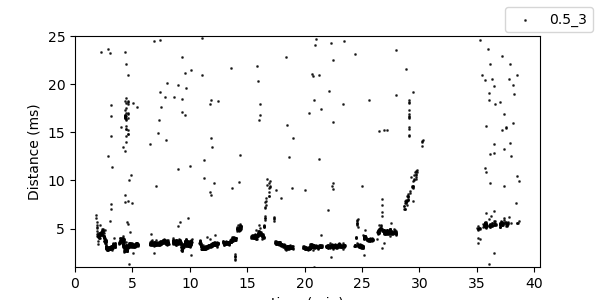

In [52]:
# inspect peak distance over time for all peaks
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter( df_all['t']/60,  (df_all['distance'])/10  , s=1, alpha=0.7, color='black', label='0.5_3')
#for xc in time_stemps:
#        plt.axvline(x = xc/60, color = 'black', linewidth=0.5, linestyle='--')
ax.set_xlabel('time (min)')
ax.set_ylabel('Distance (ms)')
ax.set_ylim(1, 25)
#ax.set_yscale('log')

fig.legend()
plt.show()

In [53]:
#Select double peak data


# all these parameters need to be adjusted !!!!!!

limit_distance_min=10 # <------------------- ADJUST ----------------->
limit_distance_max=250 # (optional)<------------------- ADJUST ----------------->
limit_primany_peak_amplitude= 20.5 #<------------------- ADJUST -----------------> #select peaks where (primary peak is bigger than Parameter)
df_sub = df_all.loc[ (df_all["distance"] > limit_distance_min) & (limit_distance_max > df_all["distance"])& (limit_primany_peak_amplitude < df_all["amplitude"])]

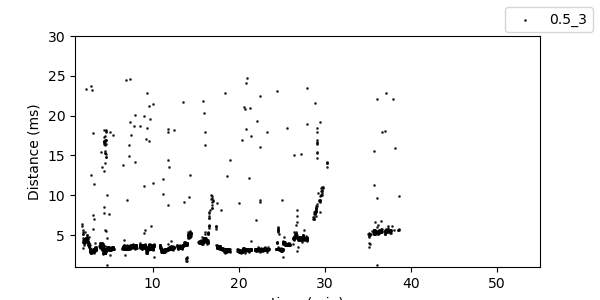

In [54]:
# peak distance over time
fig, ax = plt.subplots(figsize=(6, 3))

ax.scatter( df_sub['t']/60,  (df_sub['distance'])/10  , s=1, alpha=0.7, color='black', label='0.5_3')
#for xc in time_stemps:
#        plt.axvline(x = xc/60, color = 'black', linewidth=0.5, linestyle='--')
ax.set_xlabel('time (min)')
ax.set_ylabel('Distance (ms)')
ax.set_ylim(1,30)
ax.set_xlim(1, 55)

#ax.set_yscale('log')
#plt.grid()
fig.legend()
plt.show()

In [55]:
len(df_sub)

2425

In [56]:
fig.savefig('speed.svg', format="svg", bbox_inches='tight') # save figure

In [60]:
#save individual peak data to dataframe 
df = pd.DataFrame({"distance": df_sub['distance']/10,"time": df_sub['t']/60, "width":df_sub['width'], "amplitude":df_sub["amplitude"], 'serie':'K', 'Date':'7.08.23'} )
df.to_csv('single_K.csv', index=False) #save dataframe to csv file to analyse later 

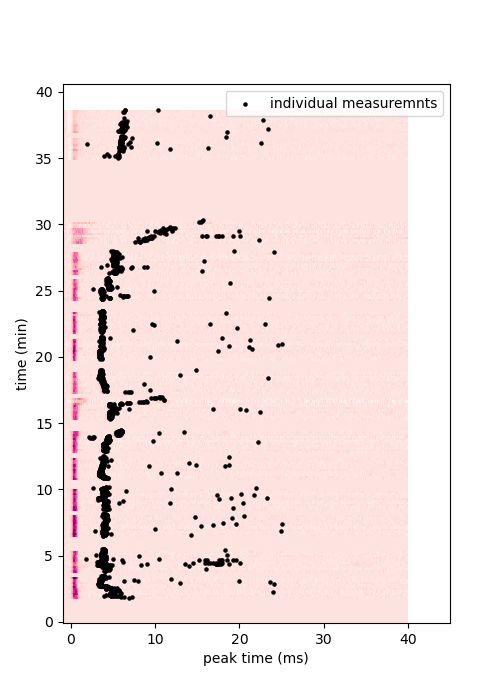

In [61]:
# Plot indivdual peak data and averaged data into the same graph for comparission


fig, ax = plt.subplots(figsize=(5, 7))
ax.pcolor(peak_time,time_position/60,grid,cmap='RdPu',shading='auto')

ax.scatter( df_sub['distance']*0.1+df_sub['width']/10,df_sub['t']/60, s=5, alpha=1, color='black',label='individual measuremnts')
#for xc in time_stemps:
#    plt.axhline(y = xc/60, color = 'black', linewidth=0.5, linestyle='--')
ax.set_ylabel('time (min)')
ax.set_xlabel('peak time (ms)')
lim = ax.get_ylim()
ax.set_xlim(-1, 45)
plt.legend()
plt.show()

In [62]:
fig.savefig('average_peak_over_time_2.svg', format="svg", bbox_inches='tight') # save figure